In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel

In [3]:
df = pd.read_csv('./dataset/data_file.csv', sep=',')
df

,FileName,md5Hash,Machine,DebugSize,DebugRVA,MajorImageVersion,MajorOSVersion,ExportRVA,ExportSize,IatVRA,MajorLinkerVersion,MinorLinkerVersion,NumberOfSections,SizeOfStackReserve,DllCharacteristics,ResourceSize,BitcoinAddresses,Benign
0,0124e21d-018c-4ce0-92a3-b9e205a76bc0.dll,79755c51e413ed3c6be4635fd729a6e1,332,0,0,0,4,0,0,8192,8,0,3,1048576,34112,672,0,1
1,05c8318f98a5d301d80000009c316005.vertdll.dll,95e19f3657d34a432eada93221b0ea16,34404,84,121728,10,10,126576,4930,0,14,10,8,262144,16864,1024,0,1
2,06054fba-5619-4a86-a861-ffb0464bef5d.dll,85c32641d77a54e19ba8ea4ab305c791,332,0,0,0,4,0,0,8192,8,0,3,1048576,34112,672,0,1
3,075822ac99a5d301660400009c316005.adhapi.dll,62e3b959d982ef534b66f819fe15f085,34404,84,19904,10,10,21312,252,18160,14,10,6,262144,16736,1040,0,1
4,090607dd9ba5d301ca0900009c316005.SensorsNative...,ae38c5f7d313ad0ff3bfb8826476767f,34404,84,97728,10,10,105792,1852,70592,14,10,7,262144,16736,1096,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62480,VirusShare_a43ceb5e5fffc793e0205d15a0606cb0,a43ceb5e5fffc793e0205d15a0606cb0,332,0,0,1,4,0,0,4096,6,0,3,1048576,0,23504,0,0
62481,VirusShare_0190dafc8304111a00fccf57340ea6a4,0190dafc8304111a00fccf57340ea6a4,332,0,0,7,10,0,0,0,7,0,7,1048576,0,15704,0,0
62482,VirusShare_0f3ca55979aaf59158d6b01140696e44,0f3ca55979aaf59158d6b01140696e44,332,0,0,0,4,0,0,404908,2,50,11,1048576,0,2364,0,0
62483,VirusShare_fca5ce35f1690db6babca5aa5d559535,fca5ce35f1690db6babca5aa5d559535,332,0,0,0,4,14448,70,4096,8,0,4,1048576,0,130296,0,0


In [4]:
header_names = ['FileName', 'md5Hash', 'Machine', 'DebugSize', 'DebugRVA', 'MajorImageVersion', 'MajorOSVersion', 
                'ExportRVA', 'ExportSize', 'IatVRA', 'MajorLinkerVersion', 'MinorLinkerVersion', 'NumberOfSections', 
                'SizeOfStackReserve', 'DllCharacteristics', 'ResourceSize', 'BitcoinAddresses', 'Benign']

categorical_columns = ['Machine', 'MajorImageVersion', 'MajorOSVersion', 'MajorLinkerVersion', 'MinorLinkerVersion', 'DllCharacteristics', 'NumberOfSections']
df[categorical_columns] = df[categorical_columns].astype('category')

binary_columns = ['Benign', 'BitcoinAddresses']

numeric_columns = df.select_dtypes(include=['int64']).columns.difference(binary_columns)

## Step 3: Data Preprocessing and Data Processing

Based on our data exploration, we observed that the two variables, 'FileName' and 'md5Hash', have unique values for each object, and therefore, we remove them from the dataset beforhand.

In [5]:
df.drop(columns=['FileName', 'md5Hash'], inplace=True)

Based on our understanding of the meaning of 'MinorLinkerVersion' and 'MajorLinkerVersion', we combine them into a single feature called 'LinkerVersion'.

In [6]:
df['LinkerVersion'] = df['MajorLinkerVersion'].astype(str) + '.' + df['MinorLinkerVersion'].astype(str)
df['LinkerVersion'] = df['LinkerVersion'].astype('category')
df.drop(columns=['MajorLinkerVersion', 'MinorLinkerVersion'], inplace=True)

categorical_columns = [col for col in categorical_columns if col not in ['MajorLinkerVersion', 'MinorLinkerVersion']]
categorical_columns.append('LinkerVersion')

As we've seen from data exploration, we try to remove 'BitcoinAddresses'

In [7]:
df.drop(columns=['BitcoinAddresses'], inplace=True)

In [8]:
df.head()

,Machine,DebugSize,DebugRVA,MajorImageVersion,MajorOSVersion,ExportRVA,ExportSize,IatVRA,NumberOfSections,SizeOfStackReserve,DllCharacteristics,ResourceSize,Benign,LinkerVersion
0,332,0,0,0,4,0,0,8192,3,1048576,34112,672,1,8.0
1,34404,84,121728,10,10,126576,4930,0,8,262144,16864,1024,1,14.10
2,332,0,0,0,4,0,0,8192,3,1048576,34112,672,1,8.0
3,34404,84,19904,10,10,21312,252,18160,6,262144,16736,1040,1,14.10
4,34404,84,97728,10,10,105792,1852,70592,7,262144,16736,1096,1,14.10


### Test 1: Consider only numerical variables (LogisticRegression)

In [9]:
X = df[numeric_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numeric_columns)  # Applica il RobustScaler alle variabili numeriche
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),         
    ('classifier', LogisticRegression())     
])

results = cross_validate(pipeline, X, y, 
                         scoring = {
                             'accuracy': make_scorer(accuracy_score),
                             'precision': make_scorer(precision_score),
                             'recall': make_scorer(recall_score)},
                         return_estimator=True, cv=10, n_jobs=-1)

print(f"Minimum accuracy={results['test_accuracy'].min():.4f}, Maximum accuracy: {results['test_accuracy'].max():.4f}, Mean accuracy: {results['test_accuracy'].mean():.4f}")
print(f"Minimum precision={results['test_precision'].min():.4f}, Maximum precision: {results['test_precision'].max():.4f}, Mean precision: {results['test_precision'].mean():.4f}")
print(f"Minimum recall={results['test_recall'].min():.4f}, Maximum recall: {results['test_recall'].max():.4f}, Mean recall: {results['test_recall'].mean():.4f}")

Minimum accuracy=0.7173, Maximum accuracy: 0.8939, Mean accuracy: 0.7958
Minimum precision=0.7593, Maximum precision: 0.9054, Mean precision: 0.8622
Minimum recall=0.4491, Maximum recall: 0.8436, Mean recall: 0.6253


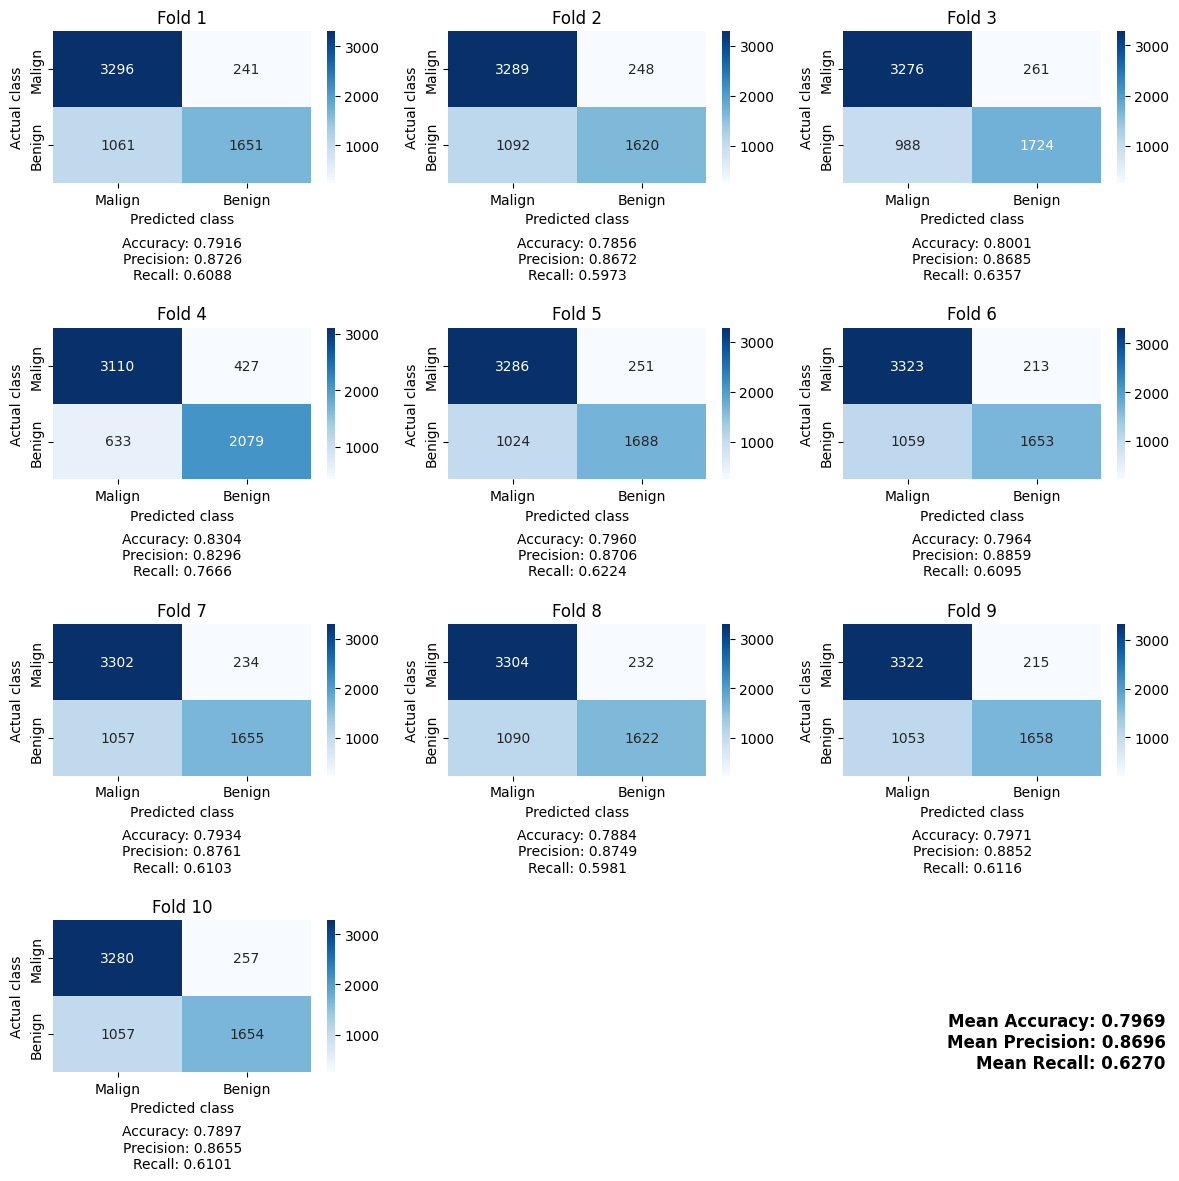

In [29]:
X = df[numeric_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numeric_columns)  # Applica il RobustScaler alle variabili numeriche
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),         
    ('classifier', LogisticRegression())     
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
conf_matrices = []

# create figure with subplots (max 3 columns for each row)
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)

    cm = confusion_matrix(y_test, y_pred)   # compute the confusion matrix
    conf_matrices.append(cm)

    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malign", "Benign"], 
                yticklabels=["Malign", "Benign"], ax=axes[i])
    metrics_text = f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}"
    axes[i].text(0.5, -0.5, metrics_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted class")
    axes[i].set_ylabel("Actual class")

# Remove empty subplots if folds < 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Print the mean of metrcs in the figure
ax_final = fig.add_subplot(111, frameon=False)  
ax_final.axis('off')

final_metrics_text = (
    f"Mean Accuracy: {np.mean(accuracy_list):.4f}\n"
    f"Mean Precision: {np.mean(precision_list):.4f}\n"
    f"Mean Recall: {np.mean(recall_list):.4f}"
)

ax_final.text(1, 0, final_metrics_text, ha='right', va='bottom', fontsize=12, fontweight='bold')


plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()

# Print final mean metrics
#print("\nFinal Results:")
#print(f"Mean Accuracy: {np.mean(accuracy_list):.4f}")
#print(f"Mean Precision: {np.mean(precision_list):.4f}")
#print(f"Mean Recall: {np.mean(recall_list):.4f}")

### Test 2: Consider only categorical variables (LogisticRegression)

In [11]:
X = df[categorical_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_transform', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

results = cross_validate(pipeline, X, y, 
                         scoring = {
                             'accuracy': make_scorer(accuracy_score),
                             'precision': make_scorer(precision_score),
                             'recall': make_scorer(recall_score)},
                         return_estimator=True, cv=10, n_jobs=-1)

print(f"Minimum accuracy={results['test_accuracy'].min():.4f}, Maximum accuracy: {results['test_accuracy'].max():.4f}, Mean accuracy: {results['test_accuracy'].mean():.4f}")
print(f"Minimum precision={results['test_precision'].min():.4f}, Maximum precision: {results['test_precision'].max():.4f}, Mean precision: {results['test_precision'].mean():.4f}")
print(f"Minimum recall={results['test_recall'].min():.4f}, Maximum recall: {results['test_recall'].max():.4f}, Mean recall: {results['test_recall'].mean():.4f}")

Minimum accuracy=0.9789, Maximum accuracy: 0.9917, Mean accuracy: 0.9859
Minimum precision=0.9776, Maximum precision: 0.9855, Mean precision: 0.9822
Minimum recall=0.9690, Maximum recall: 0.9959, Mean recall: 0.9855


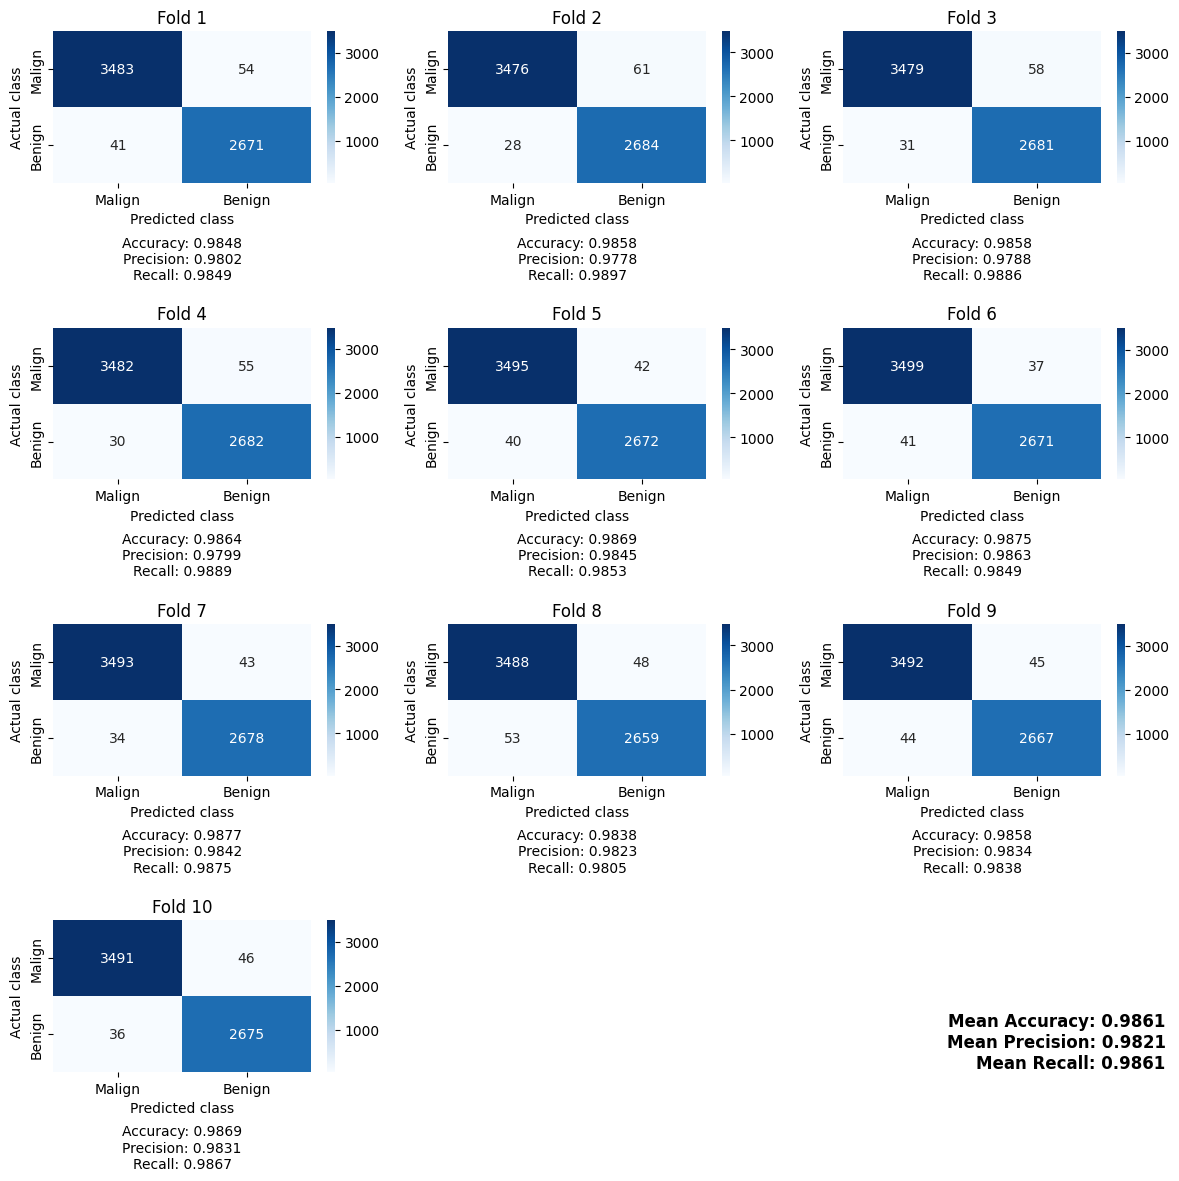

In [28]:
X = df[categorical_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_transform', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
conf_matrices = []

# create figure with subplots (max 3 columns for each row)
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)

    cm = confusion_matrix(y_test, y_pred)   # compute the confusion matrix
    conf_matrices.append(cm)

    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malign", "Benign"], 
                yticklabels=["Malign", "Benign"], ax=axes[i])
    metrics_text = f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}"
    axes[i].text(0.5, -0.5, metrics_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted class")
    axes[i].set_ylabel("Actual class")

# Remove empty subplots if folds < 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Print the mean of metrcs in the figure
ax_final = fig.add_subplot(111, frameon=False)  
ax_final.axis('off')

final_metrics_text = (
    f"Mean Accuracy: {np.mean(accuracy_list):.4f}\n"
    f"Mean Precision: {np.mean(precision_list):.4f}\n"
    f"Mean Recall: {np.mean(recall_list):.4f}"
)

ax_final.text(1, 0, final_metrics_text, ha='right', va='bottom', fontsize=12, fontweight='bold')


plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()

# Print final mean metrics
#print("\nFinal Results:")
#print(f"Mean Accuracy: {np.mean(accuracy_list):.4f}")
#print(f"Mean Precision: {np.mean(precision_list):.4f}")
#print(f"Mean Recall: {np.mean(recall_list):.4f}")

### Test 3: Consider the entire dataset (LogisticRegression)

In [13]:
X = df.drop(columns=['Benign'])
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('num_transform', Pipeline(steps=[
            ('scaler', StandardScaler())  # Normalizzazione
        ]), numeric_columns),
        ('cat_transform', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoding
        ]), categorical_columns)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(max_iter=1000))),  # Feature Selection (scegliamo tutte le features, puoi modificare k se vuoi)
    ('classifier', LogisticRegression(max_iter=1000))  # Logistic Regression
])

# Cross-validation
results = cross_validate(pipeline, X, y, 
                         scoring = {
                             'accuracy': make_scorer(accuracy_score),
                             'precision': make_scorer(precision_score),
                             'recall': make_scorer(recall_score)},
                         return_estimator=True, cv=10, n_jobs=-1)

print(f"Minimum accuracy={results['test_accuracy'].min():.4f}, Maximum accuracy: {results['test_accuracy'].max():.4f}, Mean accuracy: {results['test_accuracy'].mean():.4f}")
print(f"Minimum precision={results['test_precision'].min():.4f}, Maximum precision: {results['test_precision'].max():.4f}, Mean precision: {results['test_precision'].mean():.4f}")
print(f"Minimum recall={results['test_recall'].min():.4f}, Maximum recall: {results['test_recall'].max():.4f}, Mean recall: {results['test_recall'].mean():.4f}")

Minimum accuracy=0.9822, Maximum accuracy: 0.9920, Mean accuracy: 0.9864
Minimum precision=0.9779, Maximum precision: 0.9855, Mean precision: 0.9823
Minimum recall=0.9768, Maximum recall: 0.9963, Mean recall: 0.9864


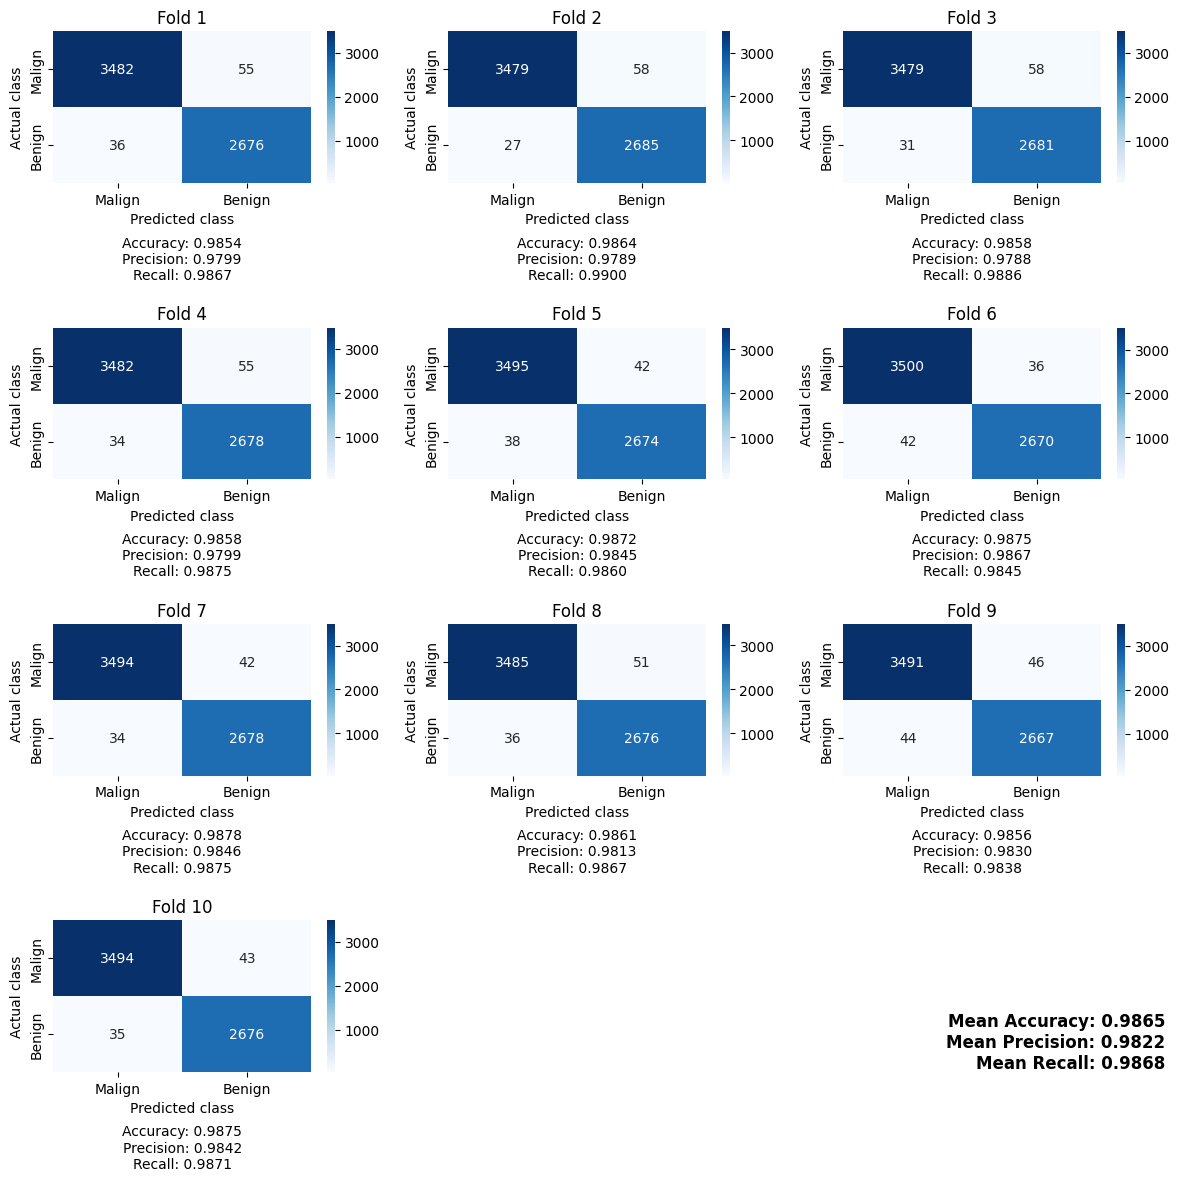


Final Results:
Mean Accuracy: 0.9865
Mean Precision: 0.9822
Mean Recall: 0.9868


In [ ]:
X = df.drop(columns=['Benign'])
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('num_transform', Pipeline(steps=[
            ('scaler', StandardScaler())  # Normalizzazione
        ]), numeric_columns),
        ('cat_transform', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoding
        ]), categorical_columns)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(max_iter=1000))),  # Feature Selection (scegliamo tutte le features, puoi modificare k se vuoi)
    ('classifier', LogisticRegression(max_iter=1000))  # Logistic Regression
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
conf_matrices = []

# create figure with subplots (max 3 columns for each row)
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)

    cm = confusion_matrix(y_test, y_pred)   # compute the confusion matrix
    conf_matrices.append(cm)

    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malign", "Benign"], 
                yticklabels=["Malign", "Benign"], ax=axes[i])
    metrics_text = f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}"
    axes[i].text(0.5, -0.5, metrics_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted class")
    axes[i].set_ylabel("Actual class")

# Remove empty subplots if folds < 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Print the mean of metrcs in the figure
ax_final = fig.add_subplot(111, frameon=False)  
ax_final.axis('off')

final_metrics_text = (
    f"Mean Accuracy: {np.mean(accuracy_list):.4f}\n"
    f"Mean Precision: {np.mean(precision_list):.4f}\n"
    f"Mean Recall: {np.mean(recall_list):.4f}"
)

ax_final.text(1, 0, final_metrics_text, ha='right', va='bottom', fontsize=12, fontweight='bold')


plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()

# Print final mean metrics
#print("\nFinal Results:")
#print(f"Mean Accuracy: {np.mean(accuracy_list):.4f}")
#print(f"Mean Precision: {np.mean(precision_list):.4f}")
#print(f"Mean Recall: {np.mean(recall_list):.4f}")

### Test 4: Consider only categorical features (RandomForest)

In [15]:
X = df[categorical_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_transform', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

results = cross_validate(pipeline, X, y, 
                         scoring = {
                             'accuracy': make_scorer(accuracy_score),
                             'precision': make_scorer(precision_score),
                             'recall': make_scorer(recall_score),
                             'f1score': make_scorer(f1_score)},
                         return_estimator=True, cv=10, n_jobs=-1)

print(f"Minimum accuracy={results['test_accuracy'].min():.4f}, Maximum accuracy: {results['test_accuracy'].max():.4f}, Mean accuracy: {results['test_accuracy'].mean():.4f}")
print(f"Minimum precision={results['test_precision'].min():.4f}, Maximum precision: {results['test_precision'].max():.4f}, Mean precision: {results['test_precision'].mean():.4f}")
print(f"Minimum recall={results['test_recall'].min():.4f}, Maximum recall: {results['test_recall'].max():.4f}, Mean recall: {results['test_recall'].mean():.4f}")
print(f"Mean f1-score: {results['test_f1score'].mean()}")

Minimum accuracy=0.9869, Maximum accuracy: 0.9942, Mean accuracy: 0.9906
Minimum precision=0.9843, Maximum precision: 0.9919, Mean precision: 0.9878
Minimum recall=0.9838, Maximum recall: 0.9978, Mean recall: 0.9907
Mean f1-score: 0.9892261057571984


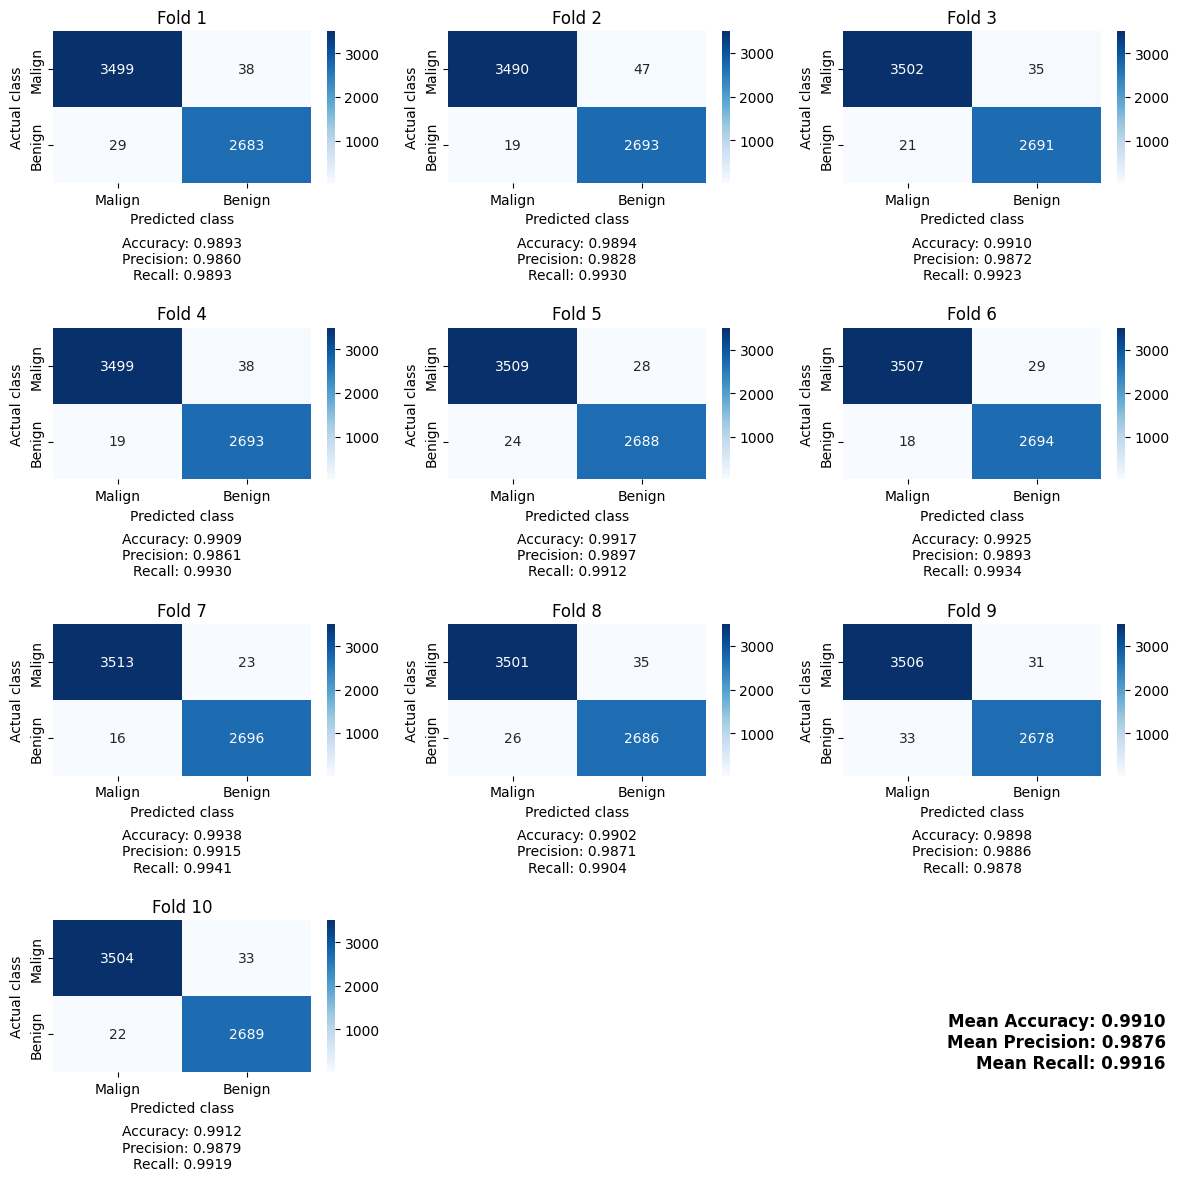

In [30]:
X = df[categorical_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_transform', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
conf_matrices = []

# create figure with subplots (max 3 columns for each row)
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)

    cm = confusion_matrix(y_test, y_pred)   # compute the confusion matrix
    conf_matrices.append(cm)

    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malign", "Benign"], 
                yticklabels=["Malign", "Benign"], ax=axes[i])
    metrics_text = f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}"
    axes[i].text(0.5, -0.5, metrics_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted class")
    axes[i].set_ylabel("Actual class")

# Remove empty subplots if folds < 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Print the mean of metrcs in the figure
ax_final = fig.add_subplot(111, frameon=False)  
ax_final.axis('off')

final_metrics_text = (
    f"Mean Accuracy: {np.mean(accuracy_list):.4f}\n"
    f"Mean Precision: {np.mean(precision_list):.4f}\n"
    f"Mean Recall: {np.mean(recall_list):.4f}"
)

ax_final.text(1, 0, final_metrics_text, ha='right', va='bottom', fontsize=12, fontweight='bold')


plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()

# Print final mean metrics
#print("\nFinal Results:")
#print(f"Mean Accuracy: {np.mean(accuracy_list):.4f}")
#print(f"Mean Precision: {np.mean(precision_list):.4f}")
#print(f"Mean Recall: {np.mean(recall_list):.4f}")

### Test 5: Consider entire dataset (Random Forest)

In [16]:
X = df.drop(columns=['Benign'])
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('num_transform', Pipeline(steps=[
            ('scaler', StandardScaler())  # Normalizzazione
        ]), numeric_columns),
        ('cat_transform', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoding
        ]), categorical_columns)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestClassifier())),  # Feature Selection (scegliamo tutte le features, puoi modificare k se vuoi)
    ('classifier', RandomForestClassifier())  # Logistic Regression
])

# Cross-validation
results = cross_validate(pipeline, X, y, 
                         scoring = {
                             'accuracy': make_scorer(accuracy_score),
                             'precision': make_scorer(precision_score),
                             'recall': make_scorer(recall_score),
                             'f1score': make_scorer(f1_score)},
                         return_estimator=True, cv=10, n_jobs=-1)

print(f"Minimum accuracy={results['test_accuracy'].min():.4f}, Maximum accuracy: {results['test_accuracy'].max():.4f}, Mean accuracy: {results['test_accuracy'].mean():.4f}")
print(f"Minimum precision={results['test_precision'].min():.4f}, Maximum precision: {results['test_precision'].max():.4f}, Mean precision: {results['test_precision'].mean():.4f}")
print(f"Minimum recall={results['test_recall'].min():.4f}, Maximum recall: {results['test_recall'].max():.4f}, Mean recall: {results['test_recall'].mean():.4f}")
print(f"Mean f1-score: {results['test_f1score'].mean()}")

Minimum accuracy=0.9949, Maximum accuracy: 0.9976, Mean accuracy: 0.9960
Minimum precision=0.9952, Maximum precision: 0.9982, Mean precision: 0.9971
Minimum recall=0.9912, Maximum recall: 0.9967, Mean recall: 0.9938
Mean f1-score: 0.995437718186861


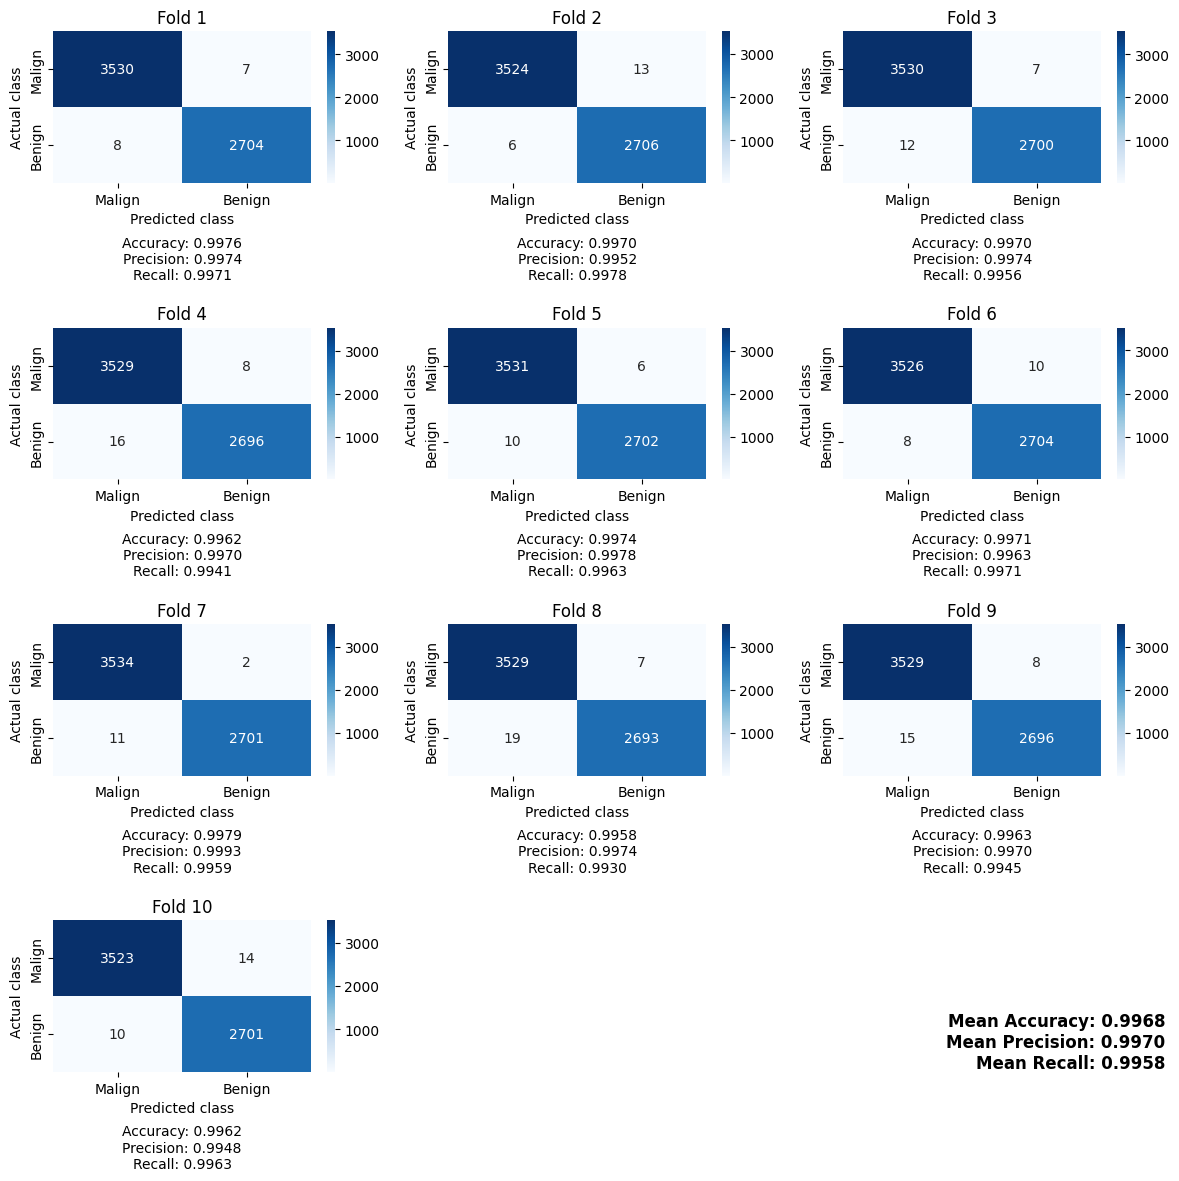

In [31]:
X = df.drop(columns=['Benign'])
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('num_transform', Pipeline(steps=[
            ('scaler', StandardScaler())  # Normalizzazione
        ]), numeric_columns),
        ('cat_transform', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoding
        ]), categorical_columns)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestClassifier())),  # Feature Selection (scegliamo tutte le features, puoi modificare k se vuoi)
    ('classifier', RandomForestClassifier())  # Logistic Regression
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
conf_matrices = []

# create figure with subplots (max 3 columns for each row)
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)

    cm = confusion_matrix(y_test, y_pred)   # compute the confusion matrix
    conf_matrices.append(cm)

    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malign", "Benign"], 
                yticklabels=["Malign", "Benign"], ax=axes[i])
    metrics_text = f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}"
    axes[i].text(0.5, -0.5, metrics_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted class")
    axes[i].set_ylabel("Actual class")

# Remove empty subplots if folds < 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Print the mean of metrcs in the figure
ax_final = fig.add_subplot(111, frameon=False)  
ax_final.axis('off')

final_metrics_text = (
    f"Mean Accuracy: {np.mean(accuracy_list):.4f}\n"
    f"Mean Precision: {np.mean(precision_list):.4f}\n"
    f"Mean Recall: {np.mean(recall_list):.4f}"
)

ax_final.text(1, 0, final_metrics_text, ha='right', va='bottom', fontsize=12, fontweight='bold')


plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()

# Print final mean metrics
#print("\nFinal Results:")
#print(f"Mean Accuracy: {np.mean(accuracy_list):.4f}")
#print(f"Mean Precision: {np.mean(precision_list):.4f}")
#print(f"Mean Recall: {np.mean(recall_list):.4f}")

### Test 6: Consider only numerical features (Random Forest)

In [17]:
X = df[numeric_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numeric_columns)  # Applica il RobustScaler alle variabili numeriche
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),         
    ('classifier', RandomForestClassifier())     
])

results = cross_validate(pipeline, X, y, 
                         scoring = {
                             'accuracy': make_scorer(accuracy_score),
                             'precision': make_scorer(precision_score),
                             'recall': make_scorer(recall_score)},
                         return_estimator=True, cv=10, n_jobs=-1)

print(f"Minimum accuracy={results['test_accuracy'].min():.4f}, Maximum accuracy: {results['test_accuracy'].max():.4f}, Mean accuracy: {results['test_accuracy'].mean():.4f}")
print(f"Minimum precision={results['test_precision'].min():.4f}, Maximum precision: {results['test_precision'].max():.4f}, Mean precision: {results['test_precision'].mean():.4f}")
print(f"Minimum recall={results['test_recall'].min():.4f}, Maximum recall: {results['test_recall'].max():.4f}, Mean recall: {results['test_recall'].mean():.4f}")

Minimum accuracy=0.9762, Maximum accuracy: 0.9923, Mean accuracy: 0.9852
Minimum precision=0.9837, Maximum precision: 0.9917, Mean precision: 0.9872
Minimum recall=0.9598, Maximum recall: 0.9956, Mean recall: 0.9785


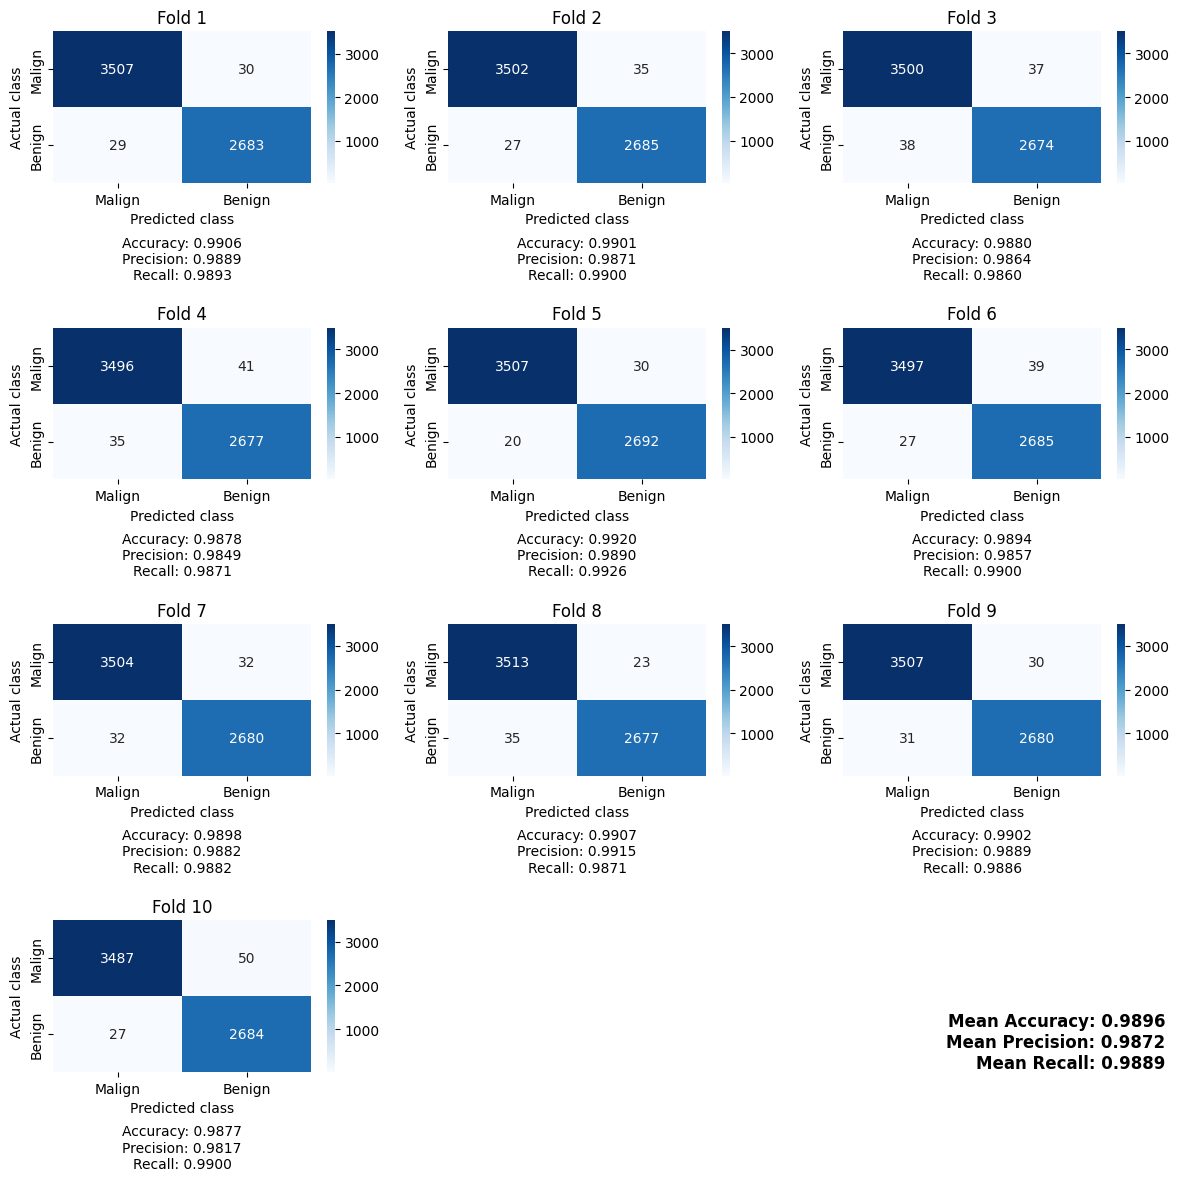

In [32]:
X = df[numeric_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numeric_columns)  # Applica il RobustScaler alle variabili numeriche
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),         
    ('classifier', RandomForestClassifier())     
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
conf_matrices = []

# create figure with subplots (max 3 columns for each row)
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)

    cm = confusion_matrix(y_test, y_pred)   # compute the confusion matrix
    conf_matrices.append(cm)

    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malign", "Benign"], 
                yticklabels=["Malign", "Benign"], ax=axes[i])
    metrics_text = f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}"
    axes[i].text(0.5, -0.5, metrics_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted class")
    axes[i].set_ylabel("Actual class")

# Remove empty subplots if folds < 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Print the mean of metrcs in the figure
ax_final = fig.add_subplot(111, frameon=False)  
ax_final.axis('off')

final_metrics_text = (
    f"Mean Accuracy: {np.mean(accuracy_list):.4f}\n"
    f"Mean Precision: {np.mean(precision_list):.4f}\n"
    f"Mean Recall: {np.mean(recall_list):.4f}"
)

ax_final.text(1, 0, final_metrics_text, ha='right', va='bottom', fontsize=12, fontweight='bold')


plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()

# Print final mean metrics
#print("\nFinal Results:")
#print(f"Mean Accuracy: {np.mean(accuracy_list):.4f}")
#print(f"Mean Precision: {np.mean(precision_list):.4f}")
#print(f"Mean Recall: {np.mean(recall_list):.4f}")
